In [ ]:
!pip install torchattacks

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

In [ ]:
import torchattacks

In [ ]:
# from torchattacks import RPGD

In [ ]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = '/gdrive/My Drive/Tmp/holdout.pth' #cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self, slope):
        super().__init__() # init the base class
        self.slope = slope

    def forward(self, input):
        return srelu(input, self.slope) # simply apply already implemented SiLU

In [ ]:
class Net(nn.Module):
    def __init__(self, slope):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.slope = slope

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = srelu(self.fc1(x), self.slope)
        x = srelu(self.fc2(x), self.slope)
        x = self.fc3(x)
        return x


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
# model = Net().to(device)

# # Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()

CUDA Available:  True


In [ ]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


# normalize to range [0 1]; also the model has been trained on this range. Later I found this is not very imortant and [-1 1] also works fine,
transform = transforms.Compose( 
    [transforms.ToTensor()]) 


# cifar10_train = dsets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


test_loader_new = torch.utils.data.DataLoader(cifar10_test, batch_size=100,
                                        shuffle=False, num_workers=1)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified


In [ ]:
import torchvision

slopes   = [.5, 1, 2, 5, 10, 100]
epsilons = [0, 0.003, 0.007, 0.01, 0.05, 0.1]
loop = [1, 2, 3, 4, 5, 6, 7]


attackNames = ['FGSM', 'BIM', 'StepLL', 'RFGSM', 'PGD', 'DeepFool']
all_accuracies = torch.empty((len(attackNames), len(slopes), len(epsilons)))


for epIdx, ep in enumerate(epsilons):
    # Run test for each slope
    for slIdx, sl in enumerate(slopes):
        # Initialize the network
        model = Net(sl).to(device)
        # model = Holdout(sl).to(device)    
        # Load the pretrained model
        model.load_state_dict(torch.load(pretrained_model, map_location='cuda'))
        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()


        FGSM = torchattacks.FGSM(model, eps=ep)
        BIM = torchattacks.BIM(model, eps=ep, alpha=1/255, iters=0)
        StepLL = torchattacks.StepLL(model, eps=ep, alpha=1/255, iters=0)
        RFGSM = torchattacks.RFGSM(model, eps=ep, alpha=8/255, iters=5)
        # CW = torchattacks.CW(model, targeted=False, c=-1, kappa=0, iters=10000, lr=0.01) # large c ignores the norm and cares about misclassification!
        PGD = torchattacks.PGD(model, eps=ep, alpha=2/255, iters=40)
        # RPGD = torchattacks.APGD(model, eps=ep, alpha=2/255, iters=40)
        DeepFool = torchattacks.DeepFool(model, iters=loop[epIdx])        
        attacks = [FGSM, BIM, StepLL, RFGSM, PGD, DeepFool]


        for attIdx, (attName, attack) in enumerate(zip(attackNames, attacks)):
            print(f'\n Running {attName}, slope={sl}, eps={ep} ... ')

            correct = 0
            total = 0

            for idx, (images, labels) in enumerate(test_loader_new):

                # attack only those that have been correctly classified
                images = images.to(device)
                labels = labels.to(device)

                init_outputs = model(images)
                _, init_pre = torch.max(init_outputs.data, 1)                
                # import pdb; pdb.set_trace()
                new_labels = labels[init_pre == labels]
                new_images = images[init_pre == labels]

                new_images = attack(new_images, new_labels)
                # plt.imshow(new_images[0].cpu().numpy().transpose(2,1,0))
                # plt.show()
                outputs = model(new_images)

                _, pre = torch.max(outputs.data, 1)

                total += len(labels)
                correct += (pre == new_labels).sum()

        #         if idx == 0:
        #             imshow(torchvision.utils.make_grid(images, nrow=10, normalize=True), '     '.join([str(i.tolist()) for i in pre]))
            acc = (100 * float(correct) / total)
            print('Test Accuracy: %f %%' % acc)
            all_accuracies[attIdx, slIdx, epIdx] = acc
                        
            


 Running FGSM, slope=0.5, eps=0 ... 
Test Accuracy: 44.350000 %

 Running BIM, slope=0.5, eps=0 ... 
Test Accuracy: 44.350000 %

 Running StepLL, slope=0.5, eps=0 ... 
Test Accuracy: 44.350000 %

 Running RFGSM, slope=0.5, eps=0 ... 
Test Accuracy: 44.350000 %

 Running PGD, slope=0.5, eps=0 ... 
Test Accuracy: 44.350000 %

 Running DeepFool, slope=0.5, eps=0 ... 
Test Accuracy: 39.540000 %

 Running FGSM, slope=1, eps=0 ... 
Test Accuracy: 57.390000 %

 Running BIM, slope=1, eps=0 ... 
Test Accuracy: 57.390000 %

 Running StepLL, slope=1, eps=0 ... 
Test Accuracy: 57.390000 %

 Running RFGSM, slope=1, eps=0 ... 
Test Accuracy: 57.390000 %

 Running PGD, slope=1, eps=0 ... 
Test Accuracy: 57.390000 %

 Running DeepFool, slope=1, eps=0 ... 
Test Accuracy: 51.350000 %

 Running FGSM, slope=2, eps=0 ... 
Test Accuracy: 57.490000 %

 Running BIM, slope=2, eps=0 ... 
Test Accuracy: 57.490000 %

 Running StepLL, slope=2, eps=0 ... 
Test Accuracy: 57.490000 %

 Running RFGSM, slope=2, eps=0 

In [ ]:
plt.imshow(new_images[0].cpu().numpy().transpose(1,2,0))
plt.show()

plt.imshow(images[0].cpu().numpy().transpose(1,2,0))
plt.show()


RuntimeError: ignored

In [ ]:
all_accuracies.shape

torch.Size([6, 6, 6])

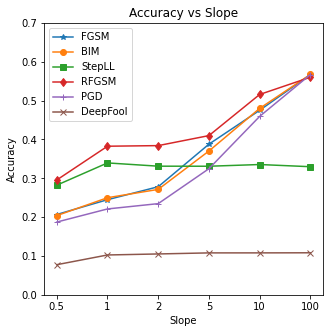

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))

res = all_accuracies.mean(axis=2)

symbs = ['*-', 'o-',  's-', 'd-', '+-', 'x-', '^-', '<-']
for idx in range(len(res)):
    plt.plot(res[idx,:]/100, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, .8, step=0.1))
plt.xticks(np.arange(0, res.shape[0], step=1), slopes)
plt.title("Accuracy vs Slope")
plt.xlabel("Slope")
plt.ylabel("Accuracy")
plt.legend(attackNames)
plt.show()
fig.savefig(f'/gdrive/My Drive/Tmp/avg-CIFAR10.png')

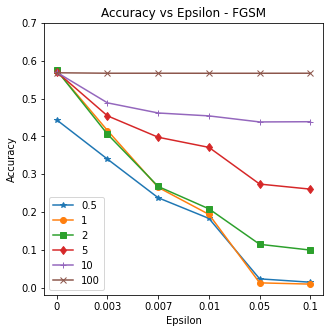

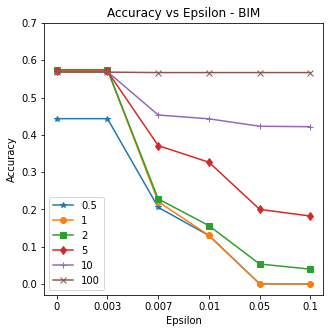

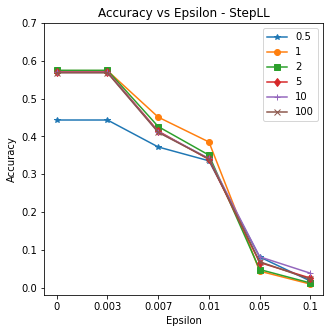

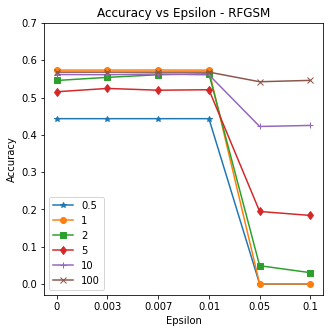

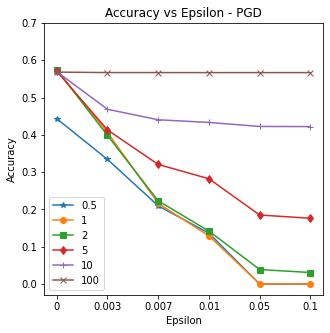

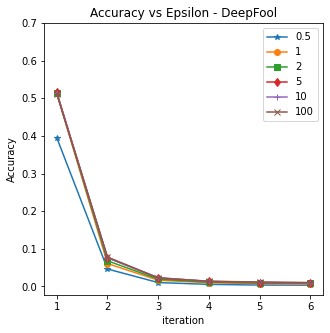

In [ ]:

loop = [1, 2, 3, 4, 5, 6]
for attIdx, att in enumerate(attackNames):
  fig = plt.figure(figsize=(5,5))
  res = all_accuracies[attIdx]

  symbs = ['*-', 'o-',  's-', 'd-', '+-', 'x-', '^-', '<-']
  for idx in range(len(res)):
      plt.plot(res[idx,:]/100, symbs[idx])
      
  #     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
  plt.yticks(np.arange(0, .8, step=0.1))
  if att in ['CW', 'DeepFool']:
    plt.xticks(np.arange(0, len(loop), step=1), loop)
    plt.xlabel("iteration")
    # plt.ylim((0,.61))
    # plt.yticks(np.arange(0, .61, step=0.1))

  else:
    # plt.xticks(epsilons,rotation=90)    
    plt.xticks(np.arange(0, len(epsilons), step=1), epsilons)
    plt.xlabel("Epsilon")
    

  plt.title(f"Accuracy vs Epsilon - {att}")
  plt.ylabel("Accuracy")
  plt.legend(slopes)
  plt.show()
  fig.savefig(f'/gdrive/My Drive/Tmp/avg-CIFAR10-{att}.png')

In [ ]:
loop

[1]

In [ ]:
# all_accuracies = torch.load('/gdrive/My Drive/Tmp/accs_CIFAR10.npy')
 np.save('/gdrive/My Drive/Tmp/accs_CIFAR10.npy', all_accuracies)

In [ ]:
attackNames

['FGSM', 'BIM', 'StepLL', 'RFGSM', 'CWPGD', 'DeepFool']

In [ ]:
!ls '/gdrive/My Drive/Tmp/'

accs_CIFAR10.npy
accs_CIFAR_Targeted.npy
accs_MNIST.npy
Activations-CIFAR10.png
Activations-MNIST.png
avg-CIFAR10-BIM.png
avg-CIFAR10-CWPGD.png
avg-CIFAR10-DeepFool.png
avg-CIFAR10-FGSM.png
avg-CIFAR10-PGD.png
avg-CIFAR10.png
avg-CIFAR10-RFGSM.png
avg-CIFAR10-StepLL.png
avg-MNIST-BIM.png
avg-MNIST-CWPGD.png
avg-MNIST-CW.png
avg-MNIST-DeepFool.png
avg-MNIST-FGSM.png
avg-MNIST-PGD.png
avg-MNIST.png
avg-MNIST-RFGSM.png
avg-MNIST-StepLL.png
cifar_net.pth
cvpr2016.pdf
Ego2Top_Matching_Viewers_in_Egocentric_and_Top_View_Videos.pdf
holdout.pth
lenet_mnist_model.pth
mnist_cnn.pth
Slopes
Slopes_CIFAR10_models.png
Slopes_CIFAR10.png
Slopes_MNIST_models.png
Slopes_MNIST.png
Targeted


In [ ]:

class NewNet(nn.Module):
    def __init__(self, act):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.act = act


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:

epsilons = [0, 0.003, 0.007, 0.01, 0.05, 0.1 ]
activations = [nn.Sigmoid(), nn.Tanh(), nn.Softsign(), nn.Softplus(), nn.CELU(), nn.ReLU()]
act_accs = torch.zeros(len(activations), len(epsilons))


for actIdx, act in enumerate(activations):
  for epIdx, ep in enumerate(epsilons):
      # Initialize the network
      model = NewNet(act).to(device)
      model.load_state_dict(torch.load(pretrained_model, map_location='cuda'))
      # Set the model in evaluation mode. In this case this is for the Dropout layers
      model.eval()


      FGSM = torchattacks.FGSM(model, eps=ep)

      correct = 0
      total = 0

      for idx, (images, labels) in enumerate(test_loader_new):

          # attack only those that have been correctly classified
          images = images.to(device)
          labels = labels.to(device)

          init_outputs = model(images)
          _, init_pre = torch.max(init_outputs.data, 1)                
          # import pdb; pdb.set_trace()
          new_labels = labels[init_pre == labels]
          new_images = images[init_pre == labels]

          new_images = FGSM(new_images, new_labels)
          outputs = model(new_images)

          _, pre = torch.max(outputs.data, 1)

          total += len(labels)
          correct += (pre == new_labels).sum()

  #         if idx == 0:
  #             imshow(torchvision.utils.make_grid(images, nrow=10, normalize=True), '     '.join([str(i.tolist()) for i in pre]))
      acc = (100 * float(correct) / total)
      print('Test Accuracy: %f %%' % acc)
      act_accs[actIdx, epIdx] = acc

Test Accuracy: 19.250000 %
Test Accuracy: 15.560000 %
Test Accuracy: 12.130000 %
Test Accuracy: 10.230000 %
Test Accuracy: 2.960000 %
Test Accuracy: 2.040000 %
Test Accuracy: 25.310000 %
Test Accuracy: 15.810000 %
Test Accuracy: 9.920000 %
Test Accuracy: 7.920000 %
Test Accuracy: 3.410000 %
Test Accuracy: 3.000000 %
Test Accuracy: 27.260000 %
Test Accuracy: 19.440000 %
Test Accuracy: 13.210000 %
Test Accuracy: 10.240000 %
Test Accuracy: 2.640000 %
Test Accuracy: 1.830000 %
Test Accuracy: 56.620000 %
Test Accuracy: 41.840000 %
Test Accuracy: 26.130000 %
Test Accuracy: 18.780000 %
Test Accuracy: 0.600000 %
Test Accuracy: 0.400000 %
Test Accuracy: 57.700000 %
Test Accuracy: 42.220000 %
Test Accuracy: 26.650000 %
Test Accuracy: 18.800000 %
Test Accuracy: 3.410000 %
Test Accuracy: 2.510000 %
Test Accuracy: 57.390000 %
Test Accuracy: 41.550000 %
Test Accuracy: 26.500000 %
Test Accuracy: 19.360000 %
Test Accuracy: 1.250000 %
Test Accuracy: 0.910000 %


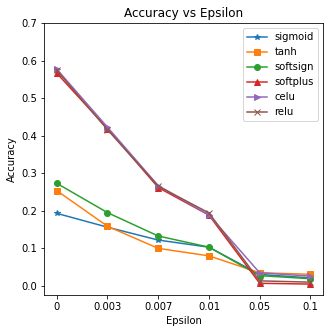

In [ ]:
fig= plt.figure(figsize=(5,5))
symbs = ['*-', 's-', 'o-', '^-', '>-', 'x-', '<-']
for idx, acc in enumerate(act_accs):
    plt.plot( acc/100, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, .8, step=0.1))
plt.xticks(np.arange(0, len(epsilons)), epsilons)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['sigmoid', 'tanh', 'softsign', 'softplus', 'celu', 'relu'])
plt.show()
fig.savefig(f'/gdrive/My Drive/Tmp/Activations-CIFAR10.png')